In [269]:
import sys
import os
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import uproot
uproot.default_library = "np"

In [270]:
global_length_cut = 0

In [271]:
os.listdir("reconstruction/")

['ckf_track_finding_performance.root',
 'layer-volumes.csv',
 'detectors.csv',
 '.nfs000000000c029aec00000007',
 'surface-grids.csv',
 'train_all',
 'torchscript',
 '.ipynb_checkpoints',
 'truth_track_finding_performance.root',
 'exatrkx_performance.root']

In [272]:
#filename = "exatrkx_performance.root"
#filename = "truth_track_finding_performance.root"
filename = "ckf_track_finding_performance.root"

In [273]:
performance_particles = uproot.open("reconstruction/{}:track_finder_particles".format(filename))
performance_tracks = uproot.open("reconstruction/{}:track_finder_tracks".format(filename))

In [274]:
particles_df = pd.DataFrame()
for key in performance_particles.keys():
    particles_df[key] = performance_particles[key].array(library="np")
    
particles_df = particles_df[ particles_df["nhits"] > global_length_cut ]
particles_df

,event_id,particle_id,particle_type,vx,vy,vz,vt,px,py,pz,m,q,nhits,ntracks,ntracks_majority
1,0,4503599660924928,211,0.000000,0.000000,0.000000,0.000000,-0.119826,0.176463,0.730273,0.13957,1.0,9,4,1
2,0,4503599694479360,211,0.000000,0.000000,0.000000,0.000000,0.186330,-0.425070,-1.008747,0.13957,1.0,13,3,2
3,0,4503599711256576,-211,0.000000,0.000000,0.000000,0.000000,0.084510,-0.164172,-1.733469,0.13957,-1.0,16,0,0
6,0,4503599761588224,-211,0.000000,0.000000,0.000000,0.000000,0.583023,0.003992,-17.064177,0.13957,-1.0,8,0,0
7,0,4503599778365440,-211,0.000000,0.000000,0.000000,0.000000,0.044175,-0.924649,-5.096349,0.13957,-1.0,13,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240980,9,900738619067596800,-211,-159.226059,-191.110199,-1633.934204,5.514487,-1.377081,-1.370586,-12.089981,0.13957,-1.0,5,0,0
240982,9,900739718612779008,-211,-5.256608,-15.141815,-1009.561829,3.371259,-0.234025,-0.095639,-5.486309,0.13957,-1.0,2,0,0
240990,9,900745216338690048,-211,2.964714,-0.863435,42.391479,0.144022,0.180777,-0.039940,2.555006,0.13957,-1.0,12,0,0
241008,9,900757311318917120,321,0.038936,0.063122,0.152181,0.000600,-0.068463,0.058455,0.651755,0.49368,1.0,13,0,0


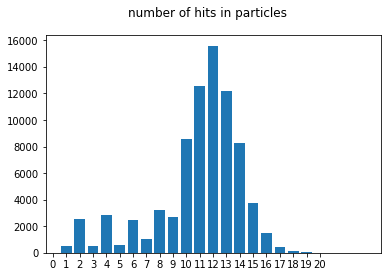

In [275]:
_ = plt.bar(*np.unique(particles_df.nhits, return_counts=True))
_ = plt.xticks(np.arange(21))
_ = plt.gcf().suptitle("number of hits in particles")

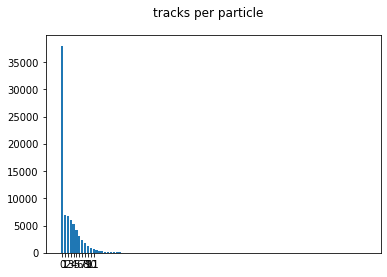

In [276]:
_ = plt.bar(*np.unique(particles_df.ntracks, return_counts=True))
_ = plt.gcf().suptitle("tracks per particle")
_ = plt.xticks(np.arange(12))

In [277]:
tracks_df = pd.DataFrame()

for key in performance_tracks.keys():
    if key not in ['particle_id', 'particle_nhits_total', 'particle_nhits_on_track']:
        tracks_df[key] = performance_tracks[key].array(library="np")
    else:
        arrays = performance_tracks[key].array(library="np")
        tracks_df[key] = [ a[0] for a in arrays ]
    
tracks_df = tracks_df.rename(columns={
    "particle_id": "maj_particle_id",
    "particle_nhits_total": "maj_particle_nhits_total",
    "particle_nhits_on_track": "maj_particle_nhits_on_track",
})

tracks_df["purity"] = tracks_df["maj_particle_nhits_on_track"] / tracks_df["size"]
tracks_df["efficiency"] = tracks_df["maj_particle_nhits_on_track"] / tracks_df["maj_particle_nhits_total"]

tracks_df = tracks_df[ tracks_df["size"] > global_length_cut ]

In [278]:
pT = np.hypot(particles_df["px"].to_numpy(), particles_df["py"].to_numpy())
tracks_df["pT"] = tracks_df["maj_particle_id"].map(dict(zip(particles_df["particle_id"], pT)))

In [279]:
p = np.hypot(pT, particles_df["pz"].to_numpy())
pL = particles_df["pz"].to_numpy()

tracks_df["eta"] = tracks_df["maj_particle_id"].map(dict(zip(particles_df["particle_id"], np.arctanh(pL/p))))
tracks_df["theta"] = tracks_df["maj_particle_id"].map(dict(zip(particles_df["particle_id"], np.degrees(np.arctan(p/pL)))))

In [280]:
tracks_df

,event_id,track_id,size,nparticles,maj_particle_id,maj_particle_nhits_total,maj_particle_nhits_on_track,purity,efficiency,pT,eta,theta
0,0,0,3,3,869204625801084928,13,1,0.333333,0.076923,0.401840,1.806003,46.546474
1,0,1,3,3,40532398508605440,9,1,0.333333,0.111111,0.063497,3.284432,45.080406
2,0,2,3,3,806144333517422592,10,1,0.333333,0.100000,0.449242,1.509057,47.799149
3,0,3,10,1,905223529480323072,11,10,1.000000,0.909091,0.898548,1.865904,46.371941
4,0,4,3,3,333304859191148544,14,1,0.333333,0.071429,1.717696,1.663325,47.056786
...,...,...,...,...,...,...,...,...,...,...,...,...
100951,9,9502,2,2,135107992008785920,14,1,0.500000,0.071429,0.302670,1.300917,49.240005
100952,9,9503,10,1,45035998706401280,11,10,1.000000,0.909091,0.415591,1.138165,50.861462
100953,9,9504,4,2,135107989307654144,13,3,0.750000,0.230769,0.827289,1.232924,49.854870
100954,9,9505,10,1,900757311335694336,11,10,1.000000,0.909091,1.415995,1.108137,51.221504


Text(0.5, 0.98, 'number of hits in reconstructed tracks')

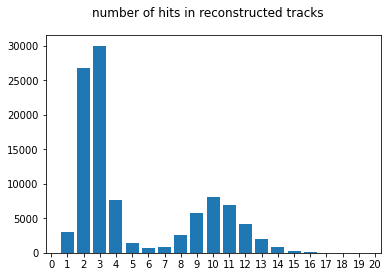

In [281]:
uniques, counts = np.unique(tracks_df["size"], return_counts=True)
plt.bar(uniques[uniques < 20], counts[uniques < 20])
_ = plt.xticks(np.arange(21))
plt.gcf().suptitle("number of hits in reconstructed tracks")

In [282]:
np.unique(tracks_df.size, return_counts=True)

(array([1211472]), array([1]))

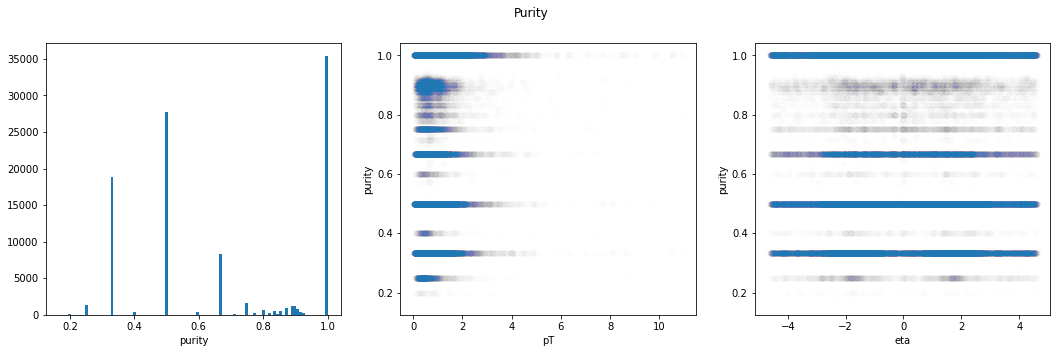

In [283]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
fig.suptitle("Purity")

_ = ax[0].hist(tracks_df["purity"], bins="rice")
_ = ax[0].set_xlabel("purity")

_ = ax[1].scatter(tracks_df["pT"], tracks_df["purity"], alpha=0.005)
_ = ax[1].set_xlabel("pT")
_ = ax[1].set_ylabel("purity")

key = "eta"
_ = ax[2].scatter(tracks_df[key], tracks_df["purity"], alpha=0.005)
_ = ax[2].set_xlabel(key)
_ = ax[2].set_ylabel("purity")

In [284]:
particles_df["pT"] = np.hypot(particles_df.px, particles_df.py)
particles_df["eta"] = np.arctanh(particles_df.pz/np.hypot(particles_df.pT, particles_df.pz))
particles_df["theta"] = np.degrees(np.arctan(np.hypot(particles_df.pT, particles_df.pz)/particles_df.pz))

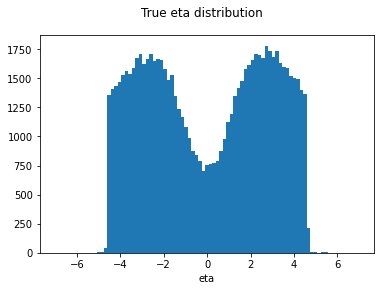

In [285]:
_ = plt.hist(particles_df["eta"], bins="rice")
_ = plt.xlabel("eta")
_ = plt.gcf().suptitle("True eta distribution")

In [286]:
f = lambda x: x.maj_particle_nhits_on_track.max() / x.maj_particle_nhits_total[x.index[0]]
efficiency = tracks_df.groupby(["maj_particle_id", "event_id"]).apply(f).reset_index()
efficiency_dict = dict(zip(list(efficiency[["maj_particle_id", "event_id"]].itertuples(index=False, name=None)), efficiency[0]))
particles_df["efficiencies"] = particles_df.set_index(['particle_id', 'event_id']).index.map(efficiency_dict).fillna(0)

particles_df

,event_id,particle_id,particle_type,vx,vy,vz,vt,px,py,pz,m,q,nhits,ntracks,ntracks_majority,pT,eta,theta,efficiencies
1,0,4503599660924928,211,0.000000,0.000000,0.000000,0.000000,-0.119826,0.176463,0.730273,0.13957,1.0,9,4,1,0.213301,1.944538,46.172348,0.111111
2,0,4503599694479360,211,0.000000,0.000000,0.000000,0.000000,0.186330,-0.425070,-1.008747,0.13957,1.0,13,3,2,0.464116,-1.518632,-47.746140,0.153846
3,0,4503599711256576,-211,0.000000,0.000000,0.000000,0.000000,0.084510,-0.164172,-1.733469,0.13957,-1.0,16,0,0,0.184646,-2.935410,-45.161606,0.000000
6,0,4503599761588224,-211,0.000000,0.000000,0.000000,0.000000,0.583023,0.003992,-17.064177,0.13957,-1.0,8,0,0,0.583036,-4.069891,-45.016708,0.000000
7,0,4503599778365440,-211,0.000000,0.000000,0.000000,0.000000,0.044175,-0.924649,-5.096349,0.13957,-1.0,13,5,3,0.925704,-2.407019,-45.464943,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240980,9,900738619067596800,-211,-159.226059,-191.110199,-1633.934204,5.514487,-1.377081,-1.370586,-12.089981,0.13957,-1.0,5,0,0,1.942899,-2.527739,-45.365215,0.000000
240982,9,900739718612779008,-211,-5.256608,-15.141815,-1009.561829,3.371259,-0.234025,-0.095639,-5.486309,0.13957,-1.0,2,0,0,0.252813,-3.771048,-45.030380,0.000000
240990,9,900745216338690048,-211,2.964714,-0.863435,42.391479,0.144022,0.180777,-0.039940,2.555006,0.13957,-1.0,12,0,0,0.185136,3.319181,45.075008,0.000000
241008,9,900757311318917120,321,0.038936,0.063122,0.152181,0.000600,-0.068463,0.058455,0.651755,0.49368,1.0,13,0,0,0.090023,2.677482,45.270699,0.000000


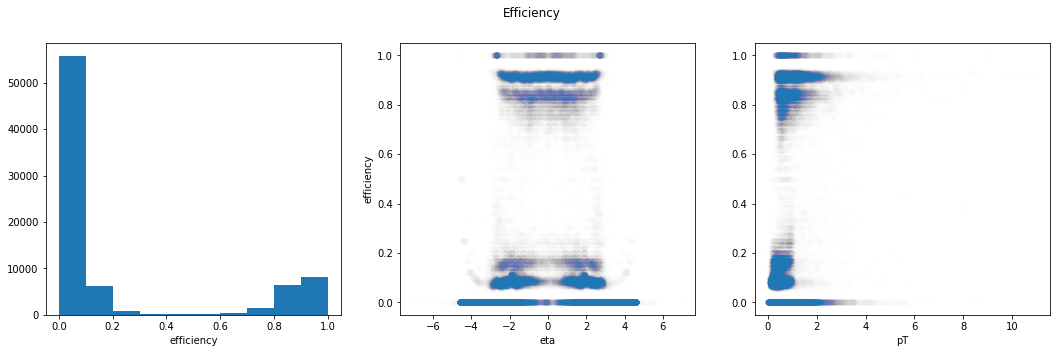

In [287]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
fig.suptitle("Efficiency")

ax[0].hist(particles_df.efficiencies)
ax[0].set_xlabel("efficiency")
#ax[0].scatter(particles_df.eta, particles_df.reconstructed, alpha=0.01)
ax[1].scatter(particles_df.eta, particles_df.efficiencies, alpha=0.005)
ax[1].set_xlabel("eta")
ax[1].set_ylabel("efficiency")
ax[2].scatter(particles_df.pT, particles_df.efficiencies, alpha=0.005)
ax[2].set_xlabel("pT")
_ = ax[1].set_ylabel("efficiency")

In [288]:
for threshold in [0.5, 0.75, 0.9, 0.999]:
    reconstructed = tracks_df[ tracks_df["efficiency"] > threshold ][["maj_particle_id","event_id"]]
    
    particles_multi_index = particles_df.set_index(["particle_id","event_id"]).index
    reconstructed_multi_index = reconstructed.set_index(["maj_particle_id","event_id"]).index
    
    particles_df["reconstructed_{}".format(int(threshold*100))] = particles_multi_index.isin(reconstructed_multi_index).astype(int)

In [289]:
def plot_binned_2d(ax, x, y, bins, threshold=10, label=None):
    hist, edges, _ = np.histogram2d(x, y, (bins,2))
    mask = np.sum(hist, axis=1) > threshold
    plotpoints = (edges[:-1] + np.diff(edges))[mask], hist[:,1][mask] / np.sum(hist, axis=1)[mask]
    ax.plot(*plotpoints, label=label)
    ax.scatter(*plotpoints)
    
    return ax

(0.0, 1.0)

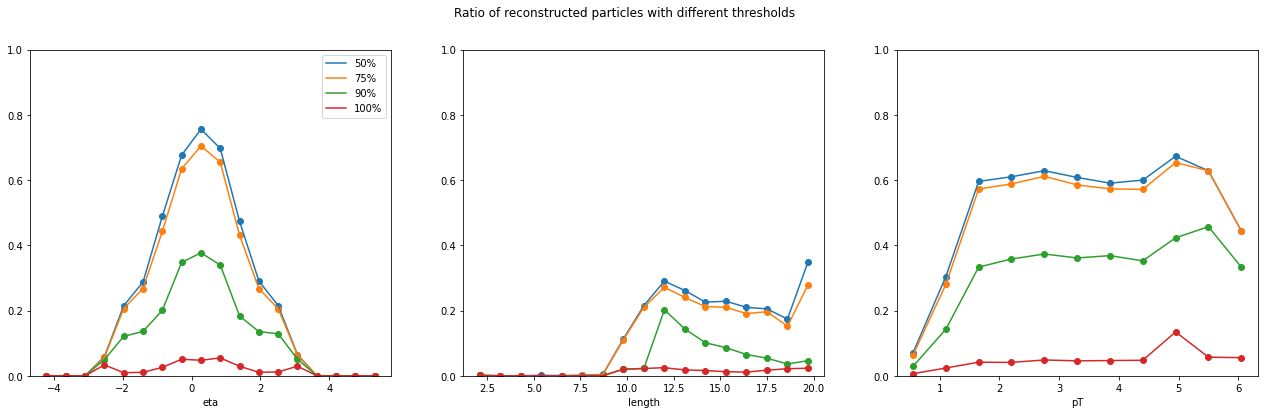

In [290]:
fig, ax = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Ratio of reconstructed particles with different thresholds")

ax[0] = plot_binned_2d(ax[0], particles_df.eta, particles_df.reconstructed_50, 25, label="50%")
ax[0] = plot_binned_2d(ax[0], particles_df.eta, particles_df.reconstructed_75, 25, label="75%")
ax[0] = plot_binned_2d(ax[0], particles_df.eta, particles_df.reconstructed_90, 25, label="90%")
ax[0] = plot_binned_2d(ax[0], particles_df.eta, particles_df.reconstructed_99, 25, label="100%")
ax[0].set_ylim(0,1)
ax[0].set_xlabel("eta")
ax[0].legend()
ax[1] = plot_binned_2d(ax[1], particles_df.nhits, particles_df.reconstructed_50, 20, label="50%")
ax[1] = plot_binned_2d(ax[1], particles_df.nhits, particles_df.reconstructed_75, 20, label="75%")
ax[1] = plot_binned_2d(ax[1], particles_df.nhits, particles_df.reconstructed_90, 20, label="90%")
ax[1] = plot_binned_2d(ax[1], particles_df.nhits, particles_df.reconstructed_99, 20, label="100%")
ax[1].set_xlabel("length")
ax[1].set_ylim(0,1)
ax[2] = plot_binned_2d(ax[2], particles_df.pT, particles_df.reconstructed_50, 20, label="50%")
ax[2] = plot_binned_2d(ax[2], particles_df.pT, particles_df.reconstructed_75, 20, label="75%")
ax[2] = plot_binned_2d(ax[2], particles_df.pT, particles_df.reconstructed_90, 20, label="90%")
ax[2] = plot_binned_2d(ax[2], particles_df.pT, particles_df.reconstructed_99, 20, label="100%")
ax[2].set_xlabel("pT")
ax[2].set_ylim(0,1)